In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')

import gc, sys
gc.enable()

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
%%time
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
del train_transaction, train_identity
gc.collect()

CPU times: user 17.4 s, sys: 3.81 s, total: 21.3 s
Wall time: 19.3 s


1249

In [3]:
%%time
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
del test_transaction, test_identity
gc.collect()

CPU times: user 16 s, sys: 3.43 s, total: 19.5 s
Wall time: 17.7 s


0

In [5]:
selected_features = [
    'TransactionAmt', 'ProductCD',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
    'P_emaildomain', 'R_emaildomain',
    'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
    'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15',
    'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12',
    'V13', 'V17', 'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36',
    'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V51',
    'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63',
    'V64', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V78',
    'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
    'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128',
    'V130', 'V131', 'V138', 'V139', 'V140', 'V143', 'V145', 'V146', 'V147', 'V149',
    'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161', 'V162',
    'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173',
    'V175', 'V176', 'V177', 'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189',
    'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207',
    'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219',
    'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229',
    'V231', 'V233', 'V234', 'V238', 'V239', 'V242', 'V243', 'V244', 'V245', 'V246',
    'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261', 'V262',
    'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273',
    'V274', 'V275', 'V276', 'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285',
    'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303', 'V304', 'V306', 'V307',
    'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324',
    'V326', 'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338',
    'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09', 'id_11', 'id_12', 'id_13', 'id_14',
    'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33', 'id_36', 'id_37',
    'id_38', 'DeviceType', 'DeviceInfo'
]

columns_to_drop = list(set(train.columns) - set(selected_features) - set(['isFraud', 'TransactionDT']))

In [6]:
train = train.drop(columns_to_drop, axis=1)
test = test.drop(columns_to_drop, axis=1)

In [7]:
train['null_columns'] = train.isna().sum(axis=1)
test['null_columns'] = test.isna().sum(axis=1)

In [9]:
train = train.fillna(-999)
test = test.fillna(-999)

In [12]:
# columns with 90% null
many_null_columns_train = [c for c in train.columns if train[c].isnull().sum() / train.shape[0] > 0.9]

many_same_values_columns_train = [c for c in train.columns if train[c].value_counts(normalize=True).values[0] > 0.9]

# value_counts(dropna=False, normalize=True)  ^^^
# commented code not needed because of 'fillna(-999)'

many_same_values_columns_test = [c for c in test.columns if test[c].value_counts(normalize=True).values[0] > 0.9]

columns_to_drop = list(set(many_same_values_columns_train + many_same_values_columns_test))
columns_to_drop.remove('isFraud')
len(columns_to_drop)

0

In [13]:
train = train.drop(columns_to_drop, axis=1)
test = test.drop(columns_to_drop, axis=1)

In [14]:
import re

os = ['Windows', 'iOS', 'Android', 'Mac OS', 'Linux']
browser = ['chrome', 'mobile safari', 'ie', 'safari', 'edge', 'firefox']
device = ['Windows', 'iOS', 'MacOS', 'SM', 'SAMSUNG', 'Moto', 'LG']

def to_pattern(x: str, patterns):
    for p in patterns:
        t = re.compile('^(' + p + ').*')
        if t.match(x):
            return p
    return 'other'

def make_os_feature(df):
    return df['id_30'].map(lambda x: to_pattern(str(x), os))

def make_browser_feature(df):
    return df['id_31'].map(lambda x: to_pattern(str(x), browser))

def make_device_feature(df):
    return df['DeviceInfo'].map(lambda x: to_pattern(str(x), device))

train['os'] = make_os_feature(train)
train['browser'] = make_browser_feature(train)
train['device'] = make_device_feature(train)

test['os'] = make_os_feature(test)
test['browser'] = make_browser_feature(test)
test['device'] = make_device_feature(test)

In [17]:
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

In [18]:
def make_aggregates(df, feature_to_group_by, feature):
    out = pd.DataFrame(index=df.index)
    
    # filter for -999 is needed because NaN values were filled by this constant
    agg = df[df[feature] != -999].groupby([feature_to_group_by])[feature]
    
    new_feature = feature + '_' + feature_to_group_by
    out[new_feature + '_mean'] = df[feature] / agg.transform('mean')
    out[new_feature + '_std' ] = df[feature] / agg.transform('std')
    
    return out

def merge_aggregates(df, feature_to_group_by, feature):
    return df.merge(make_aggregates(df, feature_to_group_by, feature), how='left', left_index=True, right_index=True)


for pair in [('card1', 'TransactionAmt'), ('card1', 'D15'), ('addr1', 'TransactionAmt')]:
    train = merge_aggregates(train, pair[0], pair[1])
    test = merge_aggregates(test, pair[0], pair[1])

In [19]:
def make_count_1(feature, df):
    temp = df[feature].value_counts(dropna=False)
    new_feature = feature + '_count'
    df[new_feature] = df[feature].map(temp)

def make_count_2(feature, train, test):
    temp = pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False)
    new_feature = feature + '_count'
    train[new_feature] = train[feature].map(temp)
    test[new_feature] = test[feature].map(temp)


for feature in ['id_01', 'id_31', 'id_33', 'id_36']:
    make_count_1(feature, train)
    make_count_1(feature, test)
    
for feature in ['card1', 'id_36']:
    make_count_2(feature, train, test)

In [20]:
def features_interaction(df, feature_1, feature_2):
    return df[feature_1].astype(str) + '_' + df[feature_2].astype(str)

features_interactions = [
    'id_02__id_20',
    'id_02__D8',
    'D11__DeviceInfo',
    'DeviceInfo__P_emaildomain',
    'P_emaildomain__C2',
    'card2__dist1',
    'card1__card5',
    'card2__id_20',
    'card5__P_emaildomain',
    'addr1__card1'
]

for new_feature in features_interactions:
    feature_1, feature_2 = new_feature.split('__')
    train[new_feature] = features_interaction(train, feature_1, feature_2)
    test[new_feature] = features_interaction(test, feature_1, feature_2)

In [22]:
def make_day_feature(df, offset=0.58, tname='TransactionDT'):
    """
    Creates a day of the week feature, encoded as 0-6.
    """
    days = df[tname] / (3600 * 24)
    encoded_days = np.floor(days - 1 + offset) % 7
    return encoded_days

def make_hour_feature(df, tname='TransactionDT'):
    """
    Creates an hour of the day feature, encoded as 0-23.
    """
    hours = df[tname] / (3600)
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

train['Weekday'] = make_day_feature(train)
train['Hour'] = make_hour_feature(train)

test['Weekday'] = make_day_feature(test)
test['Hour'] = make_hour_feature(test)

In [23]:
email_vendors = {
    'gmail': 'google',
    'att.net': 'att',
    'twc.com': 'spectrum',
    'scranton.edu': 'other',
    'optonline.net': 'other',
    'hotmail.co.uk': 'microsoft',
    'comcast.net': 'other',
    'yahoo.com.mx': 'yahoo',
    'yahoo.fr': 'yahoo',
    'yahoo.es': 'yahoo',
    'charter.net': 'spectrum',
    'live.com': 'microsoft',
    'aim.com': 'aol',
    'hotmail.de': 'microsoft',
    'centurylink.net': 'centurylink',
    'gmail.com': 'google',
    'me.com': 'apple',
    'earthlink.net': 'other',
    'gmx.de': 'other',
    'web.de': 'other',
    'cfl.rr.com': 'other',
    'hotmail.com': 'microsoft',
    'protonmail.com': 'other',
    'hotmail.fr': 'microsoft',
    'windstream.net': 'other',
    'outlook.es': 'microsoft',
    'yahoo.co.jp': 'yahoo',
    'yahoo.de': 'yahoo',
    'servicios-ta.com': 'other',
    'netzero.net': 'other',
    'suddenlink.net': 'other',
    'roadrunner.com': 'other',
    'sc.rr.com': 'other',
    'live.fr': 'microsoft',
    'verizon.net': 'yahoo',
    'msn.com': 'microsoft',
    'q.com': 'centurylink',
    'prodigy.net.mx': 'att',
    'frontier.com': 'yahoo',
    'anonymous.com': 'other',
    'rocketmail.com': 'yahoo',
    'sbcglobal.net': 'att',
    'frontiernet.net': 'yahoo',
    'ymail.com': 'yahoo',
    'outlook.com': 'microsoft',
    'mail.com': 'other',
    'bellsouth.net': 'other',
    'embarqmail.com': 'centurylink',
    'cableone.net': 'other',
    'hotmail.es': 'microsoft',
    'mac.com': 'apple',
    'yahoo.co.uk': 'yahoo',
    'netzero.com': 'other',
    'yahoo.com': 'yahoo',
    'live.com.mx': 'microsoft',
    'ptd.net': 'other',
    'cox.net': 'other',
    'aol.com': 'aol',
    'juno.com': 'other',
    'icloud.com': 'apple',
    -999: 'undefined'
}

us_emails = ['gmail', 'net', 'edu']

def transform_email(df, column):
    out = pd.DataFrame(index=df.index)
    
    # vendor
    out[column + '_vendor'] = df[column].map(email_vendors)
    
    # suffix
    out[column + '_suffix'] = df[column].map(lambda x: str(x).split('.')[-1])
    
    # US
    out[column + '_us'] = out[column + '_suffix'].map(lambda x: 'us' if str(x) in us_emails else 'other')
    
    return out

In [24]:
temp = transform_email(train, 'P_emaildomain')
train = train.merge(temp, how='left', left_index=True, right_index=True)
temp = transform_email(train, 'R_emaildomain')
train = train.merge(temp, how='left', left_index=True, right_index=True)
del temp

temp = transform_email(test, 'P_emaildomain')
test = test.merge(temp, how='left', left_index=True, right_index=True)
temp = transform_email(test, 'R_emaildomain')
test = test.merge(temp, how='left', left_index=True, right_index=True)
del temp

In [25]:
train = train.sort_values('TransactionDT').drop('TransactionDT', axis=1)
test = test.sort_values('TransactionDT').drop('TransactionDT', axis=1)

In [27]:
from sklearn.preprocessing import LabelEncoder


def encode_categorial_features_fit(df, columns_to_encode):
    encoders = {}
    for c in columns_to_encode:
        if c in df.columns:
            encoder = LabelEncoder()
            encoder.fit(df[c].astype(str).values)
            encoders[c] = encoder
    return encoders

def encode_categorial_features_transform(df, encoders):
    out = pd.DataFrame(index=df.index)
    for c in encoders.keys():
        if c in df.columns:
            out[c] = encoders[c].transform(df[c].astype(str).values)
    return out


categorial_features_columns = [
    'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21',
    'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31',
    'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
    'DeviceType', 'DeviceInfo', 'ProductCD', 'P_emaildomain', 'R_emaildomain',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'P_emaildomain_vendor', 'P_emaildomain_suffix', 'P_emaildomain_us',
    'R_emaildomain_vendor', 'R_emaildomain_suffix', 'R_emaildomain_us' # ,
    'os', 'browser', 'device'
] + features_interactions

categorial_features_encoders = encode_categorial_features_fit(
    pd.concat([train, test], join='outer', sort=False),
    categorial_features_columns)

In [28]:
temp = encode_categorial_features_transform(train, categorial_features_encoders)
columns_to_drop = list(set(categorial_features_columns) & set(train.columns))
train = train.drop(columns_to_drop, axis=1).merge(temp, how='left', left_index=True, right_index=True)
del temp

temp = encode_categorial_features_transform(test, categorial_features_encoders)
columns_to_drop = list(set(categorial_features_columns) & set(test.columns))
test = test.drop(columns_to_drop, axis=1).merge(temp, how='left', left_index=True, right_index=True)
del temp

In [29]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
#        else:
#            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [30]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 1439.22 MB
Memory usage after optimization is: 419.86 MB
Decreased by 70.8%
Memory usage of dataframe is 1233.84 MB
Memory usage after optimization is: 369.85 MB
Decreased by 70.0%


In [31]:
y_train = train['isFraud'].copy()
x_train = train.drop('isFraud', axis=1)
del train

x_test = test.copy()
del test

In [33]:
from sklearn.model_selection import KFold, train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import optuna

In [40]:
x_train.drop(['os', 'R_emaildomain_us'],axis=1,inplace=True)
x_test.drop(['os', 'R_emaildomain_us'],axis=1,inplace=True)

In [41]:
def objective(trial):
    
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'is_unbalance': False,
        'boost_from_average': True,
        'num_threads': 4,
        
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 200),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'bagging_fraction' : trial.suggest_loguniform('bagging_fraction', .5, .99),
        'feature_fraction' : trial.suggest_loguniform('feature_fraction', .5, .99),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.1, 2),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.1, 2)
    }
    
    scores = []
    
    cv = KFold(n_splits=5)
    for train_idx, valid_idx in cv.split(x_train, y_train):
        
        x_train_train = x_train.iloc[train_idx]
        y_train_train = y_train.iloc[train_idx]
        x_train_valid = x_train.iloc[valid_idx]
        y_train_valid = y_train.iloc[valid_idx]
        
        lgb_train = lgb.Dataset(data=x_train_train.astype('float32'), label=y_train_train.astype('float32'))
        lgb_valid = lgb.Dataset(data=x_train_valid.astype('float32'), label=y_train_valid.astype('float32'))
        
        lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_valid, verbose_eval=100)
        y = lgb_model.predict(x_train_valid.astype('float32'), num_iteration=lgb_model.best_iteration)
        
        score = roc_auc_score(y_train_valid.astype('float32'), y)
        print('Fold score:', score)
        scores.append(score)
    
    average_score = sum(scores) / len(scores)
    print('Average score:', average_score)
    return average_score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

[100]	valid_0's binary_logloss: 0.0727913
Fold score: 0.9037653772435538
[100]	valid_0's binary_logloss: 0.0906927
Fold score: 0.9222472959461455
[100]	valid_0's binary_logloss: 0.087174
Fold score: 0.9188195970504308
[100]	valid_0's binary_logloss: 0.0864175
Fold score: 0.9362130399437115
[100]	valid_0's binary_logloss: 0.0876126
Fold score: 0.9124173189164176
Average score: 0.9186925258200518


[I 2019-10-02 01:06:22,972] Finished trial#0 resulted in value: 0.9186925258200518. Current best value is 0.9186925258200518 with parameters: {'num_leaves': 594, 'min_data_in_leaf': 159, 'min_child_weight': 0.019631134173829584, 'max_depth': 9, 'bagging_fraction': 0.7299897165169776, 'feature_fraction': 0.7835529811894474, 'lambda_l1': 0.1595681060057512, 'lambda_l2': 0.18101288904272522}.


[100]	valid_0's binary_logloss: 0.0710649
Fold score: 0.9118757961722049
[100]	valid_0's binary_logloss: 0.0953017
Fold score: 0.9302446848213557
[100]	valid_0's binary_logloss: 0.0900128
Fold score: 0.9294392755713268
[100]	valid_0's binary_logloss: 0.0868855
Fold score: 0.9443499010548062
[100]	valid_0's binary_logloss: 0.092696
Fold score: 0.9197700571502033
Average score: 0.9271359429539793


[I 2019-10-02 01:11:09,545] Finished trial#1 resulted in value: 0.9271359429539793. Current best value is 0.9271359429539793 with parameters: {'num_leaves': 905, 'min_data_in_leaf': 132, 'min_child_weight': 0.002759286177274377, 'max_depth': 100, 'bagging_fraction': 0.6709670743998799, 'feature_fraction': 0.7479999704759364, 'lambda_l1': 0.7416015113546764, 'lambda_l2': 0.1677834775943485}.


[100]	valid_0's binary_logloss: 0.067662
Fold score: 0.9104791809144757
[100]	valid_0's binary_logloss: 0.0920337
Fold score: 0.929787692875526
[100]	valid_0's binary_logloss: 0.0870738
Fold score: 0.9278171995613765
[100]	valid_0's binary_logloss: 0.0839626
Fold score: 0.9442815910378052
[100]	valid_0's binary_logloss: 0.0893791
Fold score: 0.9202439750253874
Average score: 0.9265219278829141


[I 2019-10-02 01:14:49,232] Finished trial#2 resulted in value: 0.9265219278829141. Current best value is 0.9271359429539793 with parameters: {'num_leaves': 905, 'min_data_in_leaf': 132, 'min_child_weight': 0.002759286177274377, 'max_depth': 100, 'bagging_fraction': 0.6709670743998799, 'feature_fraction': 0.7479999704759364, 'lambda_l1': 0.7416015113546764, 'lambda_l2': 0.1677834775943485}.


[100]	valid_0's binary_logloss: 0.0686721
Fold score: 0.9103490897541588


KeyboardInterrupt: 

In [37]:
study.best_trial

Index(['os', 'R_emaildomain_us'], dtype='object')

In [42]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'is_unbalance': False,
    'boost_from_average': True,
    'num_threads': 4,
    'num_leaves': 905,
    'min_data_in_leaf': 132, 
    'min_child_weight':0.002759286177274377, 
    'max_depth': 100, 
    'bagging_fraction': 0.6709670743998799, 
    'feature_fraction': 0.7479999704759364, 
    'lambda_l1': 0.7416015113546764, 
    'lambda_l2': 0.1677834775943485}

x_train_train, x_train_valid, y_train_train, y_train_valid = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

lgb_train = lgb.Dataset(data=x_train_train.astype('float32'), label=y_train_train.astype('float32'))
lgb_valid = lgb.Dataset(data=x_train_valid.astype('float32'), label=y_train_valid.astype('float32'))

lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_valid, verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.967302
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.967302


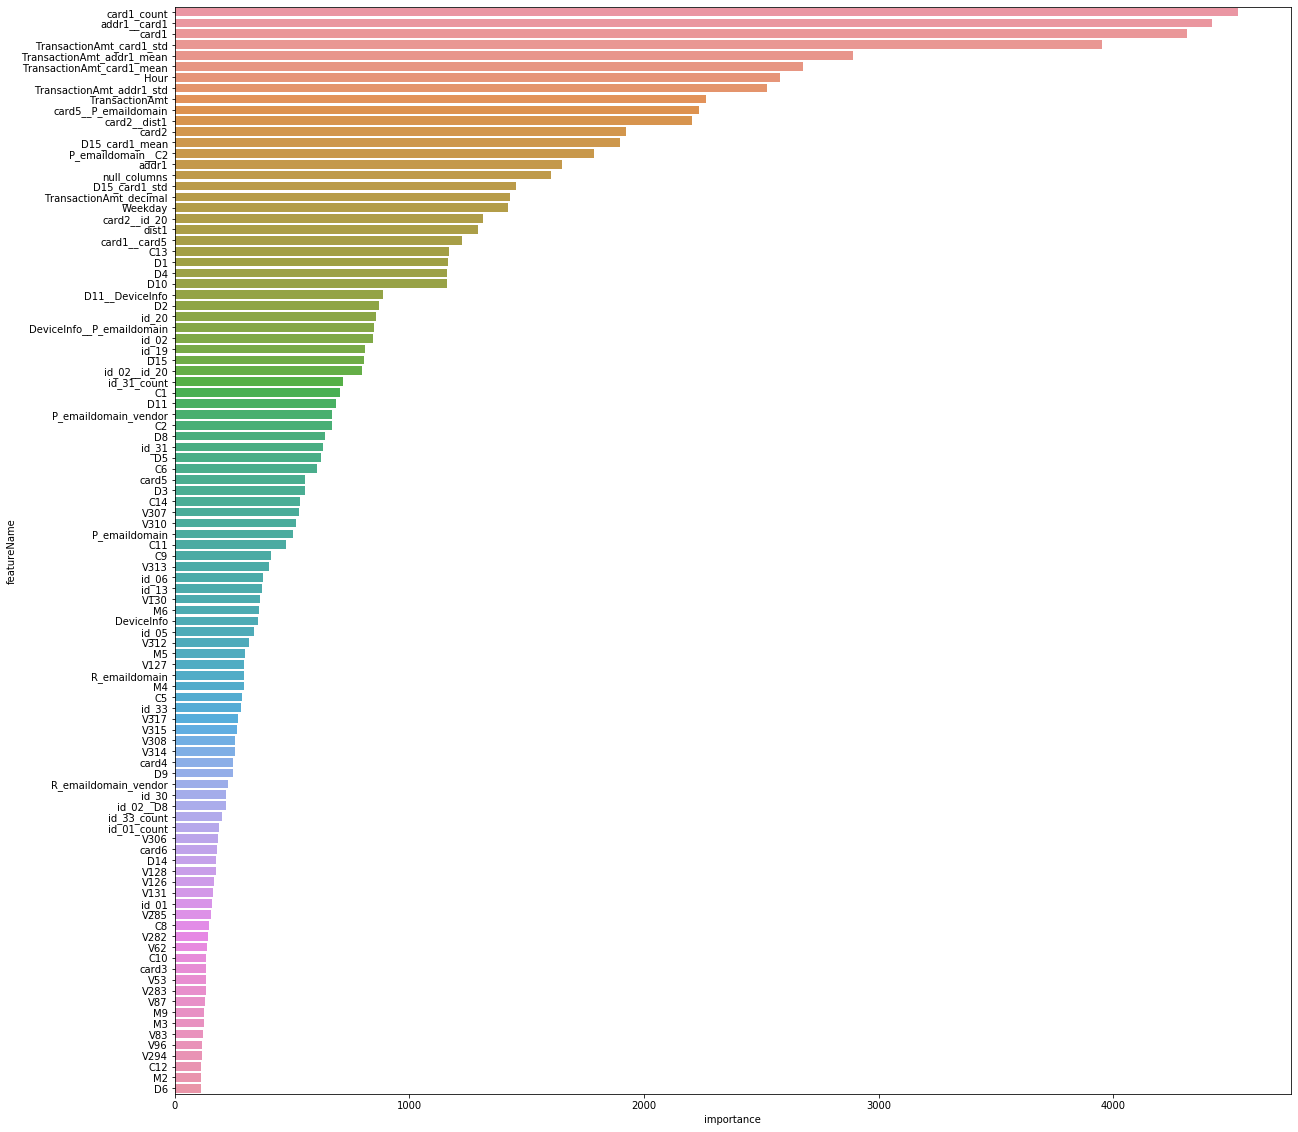

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

feature_importance_df = pd.concat([
    pd.Series(x_train.columns),
    pd.Series(lgb_model.feature_importance())], axis=1)
feature_importance_df.columns = ['featureName', 'importance']

# get top 100 features sorted by importance descending
temp = feature_importance_df.sort_values(by=['importance'], ascending=False).head(100)

plt.figure(figsize=(20, 20))
sns.barplot(x="importance", y="featureName", data=temp)
plt.show()

In [44]:
y = lgb_model.predict(x_test.astype('float32'), num_iteration=lgb_model.best_iteration)

In [46]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')
submission['isFraud'] = y
submission.to_csv('feature3_lightgbm.csv')

In [48]:
tsne=pd.read_csv('submission_IEEE.csv')

In [52]:
brend_sub=pd.DataFrame()
brend_sub['TransactionID']=tsne['TransactionID']
brend_sub['isFraud']=tsne['isFraud'].values*0.5+submission['isFraud'].values*0.5
brend_sub.to_csv('brend_tsne_lightgbm.csv',index=False)

In [53]:
brend_sub

,TransactionID,isFraud
0,3663549,0.000050
1,3663550,0.000404
2,3663551,0.000503
3,3663552,0.000227
4,3663553,0.000485
...,...,...
506686,4170235,0.005523
506687,4170236,0.004091
506688,4170237,0.002923
506689,4170238,0.006123
